### 设置超参数

In [1]:
IMG_SIZE = 625
BATCH_SIZE = 2
EPOCHS = 1000
NUM_KEYPOINTS = 4 * 2  # 4 pairs each having x and y coordinates

### 准备数据集

In [2]:
!unzip -q dataset.zip
!rm -rf ./dataset/.DS_Store

replace __MACOSX/dataset/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### 加载数据集，将数据集转换成如下格式的字典。

```json
{
  "image_path1" => [[
    627.6153846153846,
    872.6410256410256
  ], ...],
  "image_path2" => [...]
}
```

In [3]:
import json
import pathlib

json_dict = {}
for p in pathlib.Path('./dataset').glob('*'):
  path = str(p)
  with open(path + '/1.json') as file:
    json_dict[path + '/1.jpg'] = json.load(file)['shapes'][0]['points']

### 根据 `key` 获取对应 `points`

In [4]:
from PIL import Image
from matplotlib import pyplot as plt

# Utility for reading an image and for getting its annotations.
def get_dog(key):  
  data = { 'joints': json_dict[key] }
  img_data = plt.imread(key)
  # If the image is RGBA convert it to RGB.
  if img_data.shape[-1] == 4:
    img_data = img_data.astype(np.uint8)
    img_data = Image.fromarray(img_data)
    img_data = np.array(img_data.convert("RGB"))
  data['img_data'] = img_data
  return data

### 定义显示关键点方法

In [5]:
import numpy as np
from imgaug.augmentables.kps import KeypointsOnImage

def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c='red', marker="x", s=50, linewidths=5
                )
        else:
            current_keypoint = np.array(current_keypoint)
            # Since the last entry is the visibility flag, we discard it.
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], c='red', marker="x", s=50, linewidths=5)

    plt.tight_layout(pad=2.0)
    plt.show()

### 检查一下数据

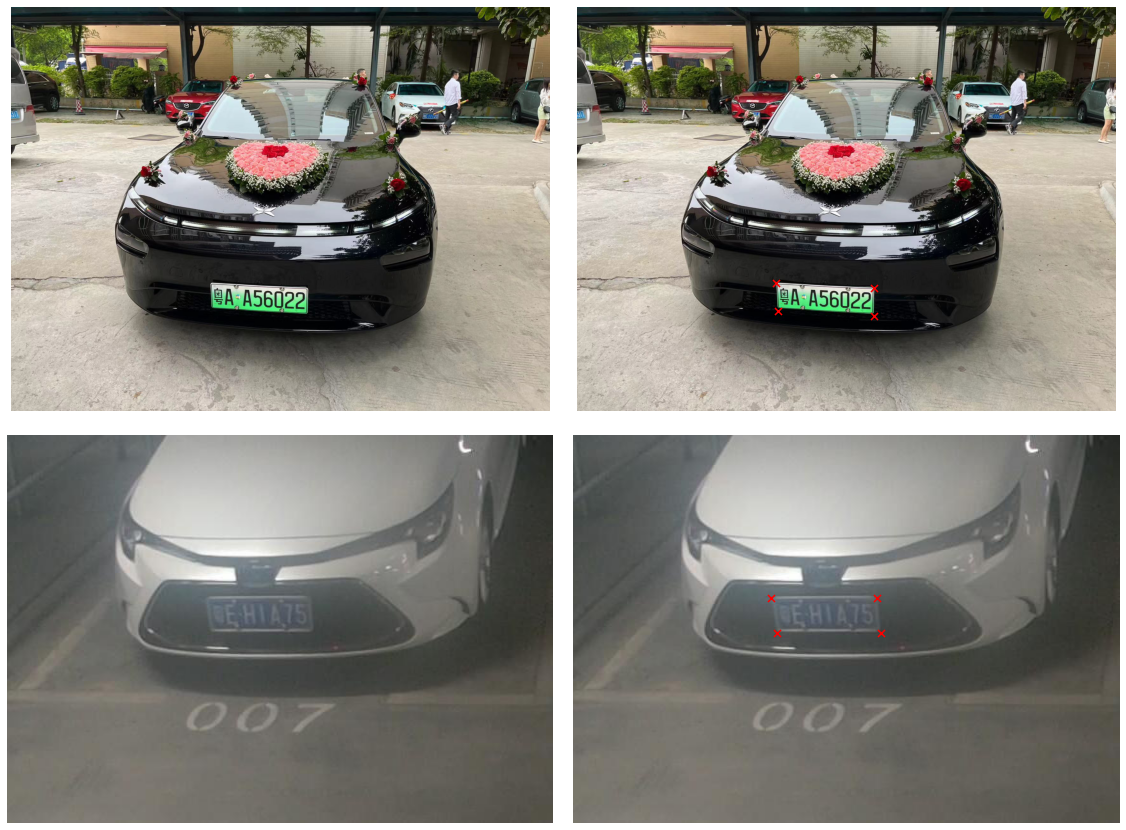

In [6]:
# 选取两个样本检查
samples = list(json_dict.keys())
num_samples = 2
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_dog(sample)
    images.append(data["img_data"])
    keypoints.append(data["joints"])

visualize_keypoints(images, keypoints)

### 构建数据生成器

In [7]:
from tensorflow import keras
from imgaug.augmentables.kps import Keypoint

class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_dog(key)
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj.keypoints:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 4 * 2)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)

In [8]:
import imgaug.augmenters as iaa

train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        #iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        #iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

### 准备训练集和验证集

In [9]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)

### 检查训练集和验证集

Total batches in training set: 1
Total batches in validation set: 0


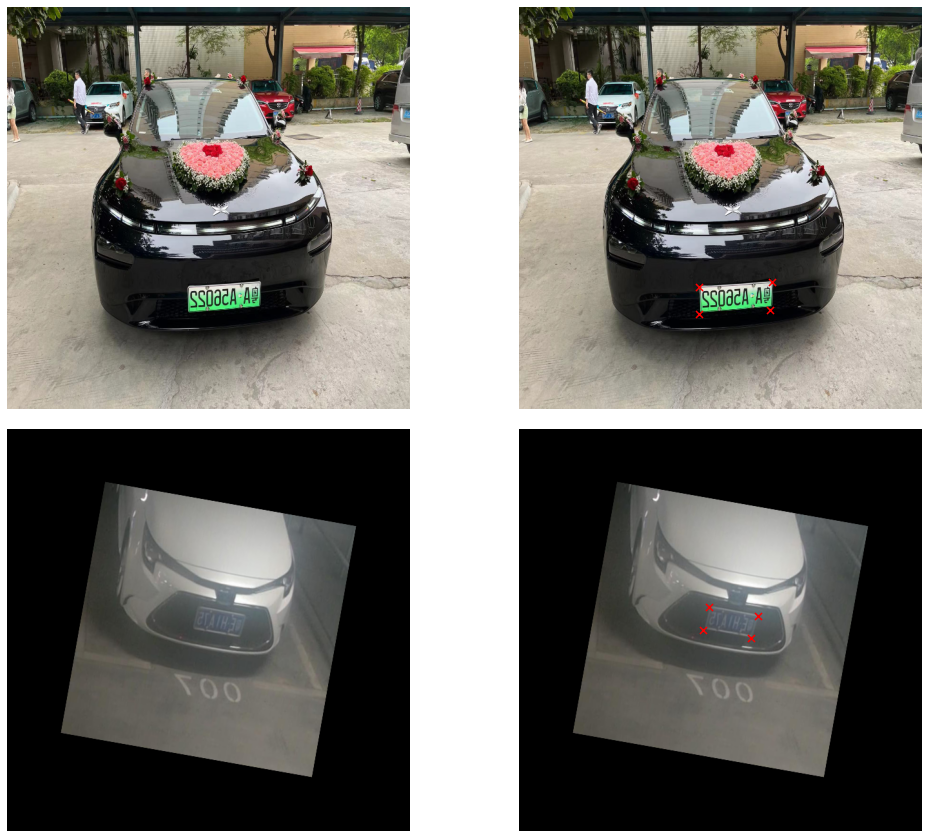

In [10]:
train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))

sample_keypoints = sample_keypoints[:4].reshape(-1, 4, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

### 构建模型

In [11]:
from tensorflow.keras import layers

# def get_model():
#     # Load the pre-trained weights of MobileNetV2 and freeze the weights
#     backbone = keras.applications.MobileNetV2(
#         weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
#     )
#     backbone.trainable = False

#     inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
#     x = keras.applications.mobilenet_v2.preprocess_input(inputs)
#     x = backbone(x)
#     x = layers.Dropout(0.3)(x)
#     x = layers.SeparableConv2D(NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu")(x)
#     outputs = layers.SeparableConv2D(NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid")(x)

#     return keras.Model(inputs, outputs, name="keypoint_detector")

In [12]:
import tensorflow as tf

def get_model():
  inputs = keras.layers.Input((IMG_SIZE, IMG_SIZE, 3))
  x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(inputs)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same', strides=2)(x)
  x = tf.keras.layers.Conv2D(filters=96, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same', strides=2)(x)  
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same', strides=2)(x)    
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same', strides=2)(x)    
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same', strides=2)(x)       
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same', strides=2)(x)           
  x = layers.SeparableConv2D(NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu")(x)
  x = layers.SeparableConv2D(NUM_KEYPOINTS, kernel_size=3, strides=1, activation="relu")(x)   
  x = layers.SeparableConv2D(NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid")(x) 
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same', strides=2)(x) 
  return keras.models.Model(inputs=inputs, outputs=x) 

### 生成模型

In [13]:
model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4))
get_model().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 625, 625, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 625, 625, 128)     3584      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 313, 313, 128)    0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 313, 313, 96)      110688    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 157, 157, 96)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 157, 157, 64)      5536

### 预览模型架构

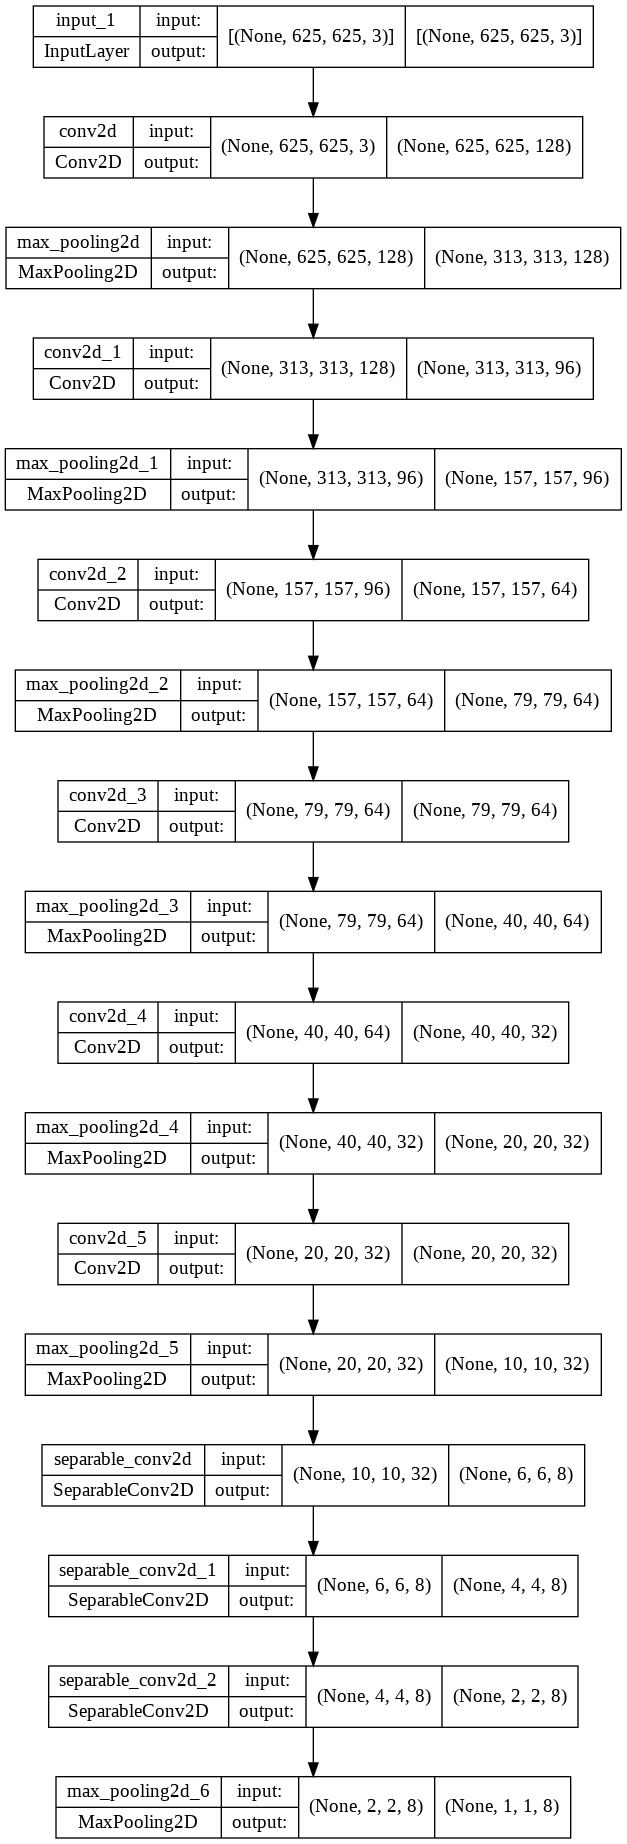

In [14]:
import tensorflow as tf

tf.keras.utils.plot_model(model, show_shapes=True)

### 训练

In [15]:
model.fit(train_dataset, validation_data=train_dataset, epochs=EPOCHS)

Epoch 1/1000
1/1 [==============================] - 5s 5s/step - loss: 0.0190 - val_loss: 0.0173
Epoch 2/1000
1/1 [==============================] - 0s 252ms/step - loss: 0.0153 - val_loss: 0.0165
Epoch 3/1000
1/1 [==============================] - 0s 254ms/step - loss: 0.0162 - val_loss: 0.0068
Epoch 4/1000
1/1 [==============================] - 0s 249ms/step - loss: 0.0162 - val_loss: 0.0157
Epoch 5/1000
1/1 [==============================] - 0s 258ms/step - loss: 0.0138 - val_loss: 0.0099
Epoch 6/1000
1/1 [==============================] - 0s 252ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 7/1000
1/1 [==============================] - 0s 248ms/step - loss: 0.0148 - val_loss: 0.0114
Epoch 8/1000
1/1 [==============================] - 0s 258ms/step - loss: 0.0118 - val_loss: 0.0088
Epoch 9/1000
1/1 [==============================] - 0s 251ms/step - loss: 0.0141 - val_loss: 0.0115
Epoch 10/1000
1/1 [==============================] - 0s 265ms/step - loss: 0.0138 - val_loss: 0.0078
Ep

### 显示训练结果

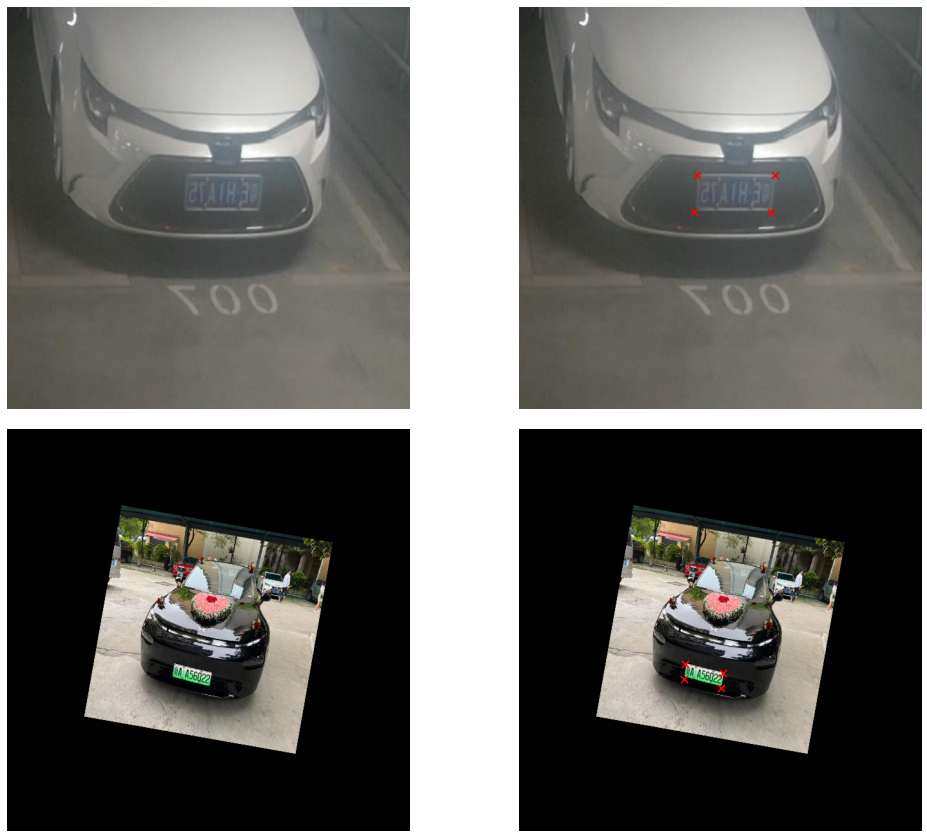

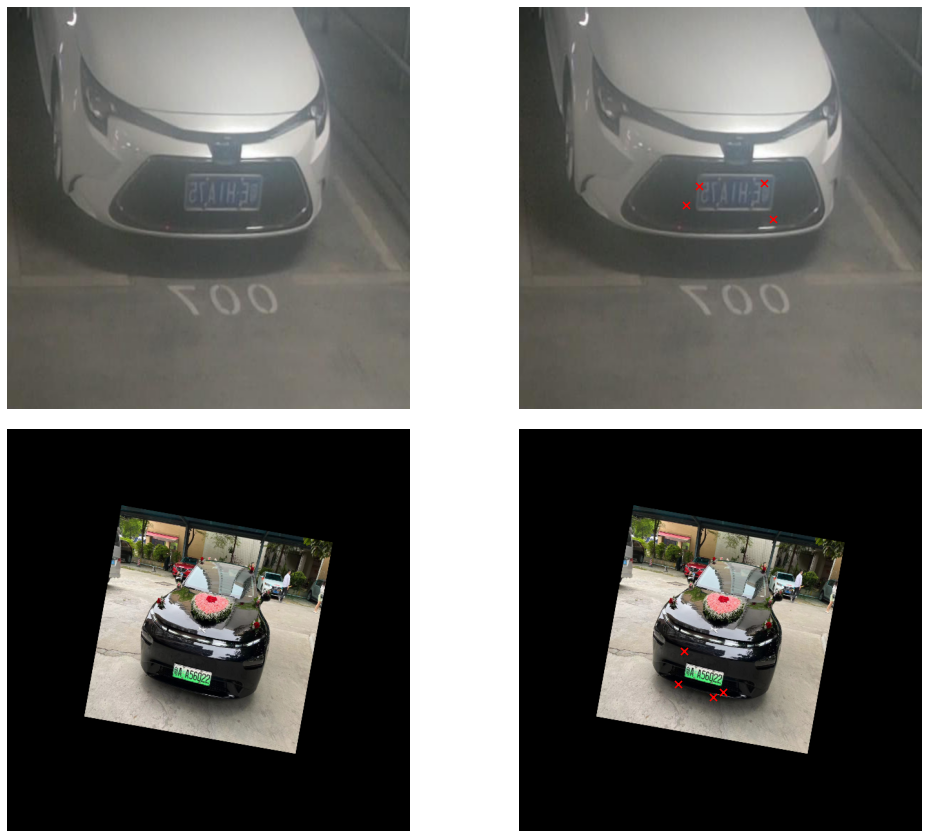

In [16]:
sample_val_images, sample_val_keypoints = next(iter(train_dataset))
sample_val_images = sample_val_images[:2]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 4, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 4, 2) * IMG_SIZE

# Ground-truth
visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
visualize_keypoints(sample_val_images, predictions)